In [21]:
%pip install -qq matplotlib
%pip install -qq torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install -qq scikit-learn



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

print("CUDA disponible :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nom du GPU :", torch.cuda.get_device_name(0))


CUDA disponible : True
Nom du GPU : NVIDIA GeForce RTX 4060 Laptop GPU


In [22]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF


class SARDatasetNpy(Dataset):
    def __init__(self, images_dir, masks_dir, size=(128, 128)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.size = size
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".npy")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)

        image = np.load(img_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.float32)

        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        if image.ndim == 2:
            image = np.expand_dims(image, axis=0)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=0)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        image = TF.resize(image, self.size, interpolation=TF.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=TF.InterpolationMode.NEAREST)

        mask = (mask > 0).float()
        return image, mask


In [23]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

full_dataset = SARDatasetNpy("data/sar_data_amplitude/", "data/labels_1c/")

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)


In [24]:
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU()
            )

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = CBR(256, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))

In [25]:
model = UNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

best_val_loss = float('inf')
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"📘 Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Nouveau meilleur modèle sauvegardé.")


📘 Epoch 1/5 — Train Loss: 0.0953 | Val Loss: 0.0573
💾 Nouveau meilleur modèle sauvegardé.
📘 Epoch 2/5 — Train Loss: 0.0453 | Val Loss: 0.0367
💾 Nouveau meilleur modèle sauvegardé.
📘 Epoch 3/5 — Train Loss: 0.0406 | Val Loss: 0.0363
💾 Nouveau meilleur modèle sauvegardé.
📘 Epoch 4/5 — Train Loss: 0.0354 | Val Loss: 0.0355
💾 Nouveau meilleur modèle sauvegardé.
📘 Epoch 5/5 — Train Loss: 0.0358 | Val Loss: 0.0317
💾 Nouveau meilleur modèle sauvegardé.


In [31]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, loader, device, num_samples=4):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(loader))
        images = images.to(device)
        masks = masks.to(device)
        preds = model(images)

    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, images.size(0))):
        # Image originale
        plt.subplot(3, num_samples, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        plt.title("Image")
        plt.axis('off')

        # Masque réel
        plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(masks[i][0].cpu(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        # Prédiction
        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow((preds[i][0].cpu() > 0.5), cmap='gray')
        plt.title("Pred")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def compute_iou(model, loader, device, threshold=0.5):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            preds = (preds > threshold).float()

            intersection = (preds * masks).sum(dim=(1, 2, 3))
            union = ((preds + masks) >= 1).float().sum(dim=(1, 2, 3))

            iou = (intersection / (union + 1e-8)).cpu().numpy()
            iou_scores.extend(iou)

    return sum(iou_scores) / len(iou_scores)

def compute_dice(model, loader, device, threshold=0.5):
    model.eval()
    dice_scores = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            preds = (preds > threshold).float()

            intersection = (preds * masks).sum(dim=(1, 2, 3))
            total = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3))

            dice = (2.0 * intersection / (total + 1e-8)).cpu().numpy()
            dice_scores.extend(dice)

    return sum(dice_scores) / len(dice_scores)

def compute_precision_recall_f1(model, loader, device, threshold=0.5):
    model.eval()
    tp = 0
    fp = 0
    fn = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            preds = (preds > threshold).float()

            tp += ((preds == 1) & (masks == 1)).sum().item()
            fp += ((preds == 1) & (masks == 0)).sum().item()
            fn += ((preds == 0) & (masks == 1)).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return precision, recall, f1



C:\Users\ghodb\AppData\Local\Temp\ipykernel_29596\2713793870.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


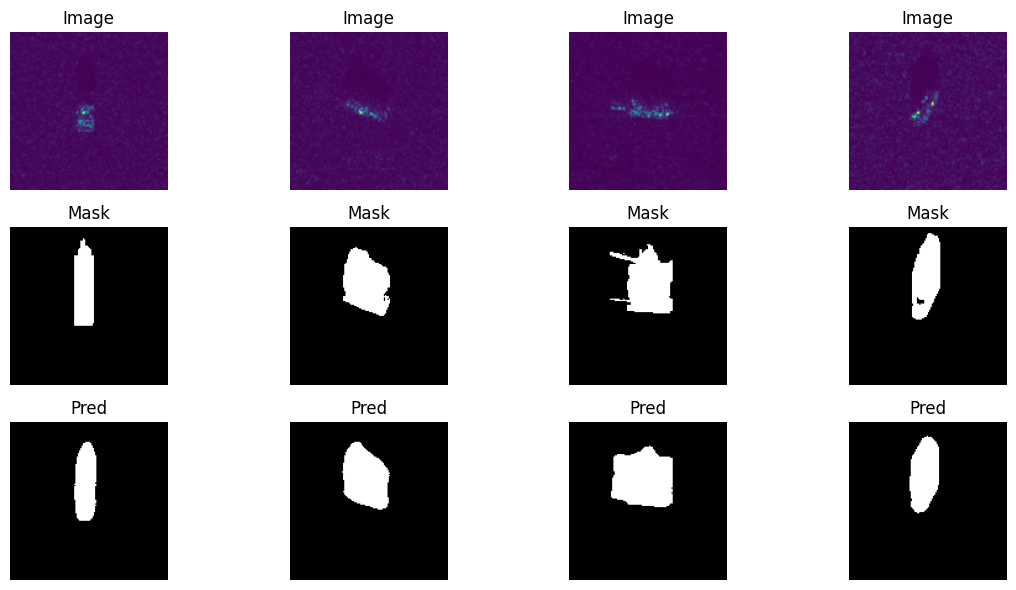

✅ Test IoU: 0.8550
🎯 Dice Score (Test) : 0.9211
✅ Précision : 0.9245
📈 Rappel    : 0.9196
🎯 F1-score  : 0.9221


In [32]:
model = UNet()  
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)

visualize_predictions(model, test_loader, device)
test_iou = compute_iou(model, test_loader, device)
dice_score = compute_dice(model, test_loader, device)

precision, recall, f1 = compute_precision_recall_f1(model, test_loader, device)

print(f"✅ Test IoU: {test_iou:.4f}")
print(f"🎯 Dice Score (Test) : {dice_score:.4f}")
print(f"✅ Précision : {precision:.4f}")
print(f"📈 Rappel    : {recall:.4f}")
print(f"🎯 F1-score  : {f1:.4f}")

